<a href="https://colab.research.google.com/github/azfarkhoja305/Handwritten-RNNs/blob/master/Conditional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/azfarkhoja305/Handwritten-RNNs.git

In [0]:
import random
import math
import pdb
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'./Handwritten-RNNs/Handwritten-RNNs')

from utils import *
from utils.other_utils import *
from models.synthesis import Synthesis

In [0]:
Path.ls = lambda x : list(x.iterdir())

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
project_path = Path('./Handwritten-RNNs/Handwritten-RNNs')
data_path = project_path/'data'

In [0]:
# Load data
strokes = np.load(data_path/'strokes-py3.npy', allow_pickle=True)
with open(data_path/'sentences.txt') as f:
    texts = f.readlines()

In [13]:
# Process text data
process_text = ProcessText()
# tokenize
char_list = process_text.tokenize(texts)
char_list[3][:10]

['<start>', 'p', 'r', 'e', 'v', 'i', 'o', 'u', 's', ' ']

In [14]:
# create vocab
word2idx,idx2word = process_text.create_vocab()
len(word2idx)

80

In [15]:
# numericalize
char_data = process_text.numericalize()
char_data[3][:10]

[26, 69, 71, 58, 75, 62, 68, 74, 72, 1]

In [16]:
# sanity check
len(char_data[0]),len(char_list[0])

(28, 28)

In [0]:
# normalize and add tokens to strokes
process_strokes = ProcessStrokes()
norm_strokes = process_strokes.normalize(copy.deepcopy(strokes))
final_strokes =  process_strokes.add_tokens(copy.deepcopy(norm_strokes))

In [0]:
# 10% data for validation 
cutoff = round(0.1*len(final_strokes))
cutoff

600

In [0]:
# Split data
train_data = char_data[cutoff:],final_strokes[cutoff:]
valid_data = char_data[:cutoff],final_strokes[:cutoff]

In [0]:
# Custom Dataset
train_dataset = CustomDataset(*train_data)
valid_dataset = CustomDataset(*valid_data)

In [0]:
len(train_dataset), len(valid_dataset)

(5400, 600)

In [0]:
# Using a custom collate_fn
train_loader = DataLoader(train_dataset,batch_size=256,shuffle=True,collate_fn=custom_collate)
valid_loader = DataLoader(valid_dataset,batch_size=300,collate_fn=custom_collate)

In [0]:
# If GPU available
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using the GPU


In [0]:
# detach hidden states to prevent backprop through the entire sequence
def repackage_hidden(new_state):
    if isinstance(new_state,torch.Tensor): 
        return new_state.detach()
    else: 
        return tuple(repackage_hidden(h) for h in new_state)

In [0]:
# split the incoming data into chunks of bptt length
bptt = 400
def train_epoch(model, train_loader,opt,len_train,clip_norm):
    model.train()
    train_metric.reset_state()
    new_state = None
    for x,y in tqdm(train_loader,total=len_train):
        x,y = x.to(device), y.to(device)
        state,kappa = None, 0
        context = torch.zeros((x.size(0),1,enc_sz),dtype=torch.float32).to(device)

        for i in range(math.ceil(y.size(1)/bptt)):
            y_inp = y[:,i*bptt:(i+1)*bptt]     
            y_op = y[:,i*bptt+1:(i+1)*bptt+1] # remove first token
            if y_inp.size() != y_op.size(): # last bptt element
                pad = torch.as_tensor([4,0.,0.]).view(1,1,-1).expand(y_inp.size(0),1,3).to(device)
                y_op = torch.cat([y_op,pad],1)

            params, state, context, kappa = model(x,y_inp,state,context,kappa)
            state, context, kappa = repackage_hidden((state, context, kappa))
            loss = mask_loss_func(params,y_op)
            train_metric.update_state(params,y_op)
            model.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(),clip_norm)
            opt.step()

In [0]:
# track metrics for the entire epochs
train_metric = LossMetric(mask_end=False)
valid_metric = LossMetric(mask_end=False)

# loss for the strokes (0,1,start,stop,pad)
loss_ce = nn.CrossEntropyLoss(reduction='none')

In [0]:
# Mask only padding this case
def mask_loss_func(preds, y_true):
    intrp,coords = y_true[:,:,0].long(), y_true[:,:,1:]
    mask = (~(intrp==4)).float()
    ce_preds,pi = preds[:2]
    ce_preds = ce_preds.transpose(-1,1)
    ce = loss_ce(ce_preds, intrp)
    ce = mask*ce

    probs = pi*calc_prob(coords,* preds[2:]) 
    probs = torch.sum(probs,-1)
    nll = -mask*(torch.log(probs+ 1e-10))
    if torch.isnan(nll.sum()):
        pdb.set_trace()
    return (ce.sum()+ nll.sum()) /mask.sum()

In [0]:
def valid_epoch(model, valid_loader,len_val):
    model.eval()
    valid_metric.reset_state()
    with torch.no_grad():
        for x,y in valid_loader:
            state,kappa = None, 0
            context = torch.zeros((x.size(0),1,enc_sz),dtype=torch.float32).to(device)
            x,y = x.to(device), y.to(device)
            params = model(x, y[:,:-1], state, context, kappa)[0]
            valid_metric.update_state(params,y[:,1:])

In [0]:
def fit(model,epochs,max_lr,clip=0.4,wd=0):

    opt = torch.optim.AdamW(model.parameters(), lr = max_lr, weight_decay=wd,betas= [0.95,0.999])
    lr = list(np.linspace(1e-6,max_lr,epochs//2)) + list(np.linspace(max_lr,1e-6,math.ceil(epochs/2)))
    mom = list(np.linspace(0.95,0.85,epochs//2)) + list(np.linspace(0.85,0.95,math.ceil(epochs/2)))
    train_logs = {'ce_tl':[],'nll_tl':[],'tot_tl':[],'ce_vl':[],'nll_vl':[],'tot_vl':[],}
    best_valid_loss = float('inf')
    len_train,len_val = len(train_loader), len(valid_loader)
    for e in tqdm(range(epochs)):
        opt.defaults['lr'] = lr[e]
        opt.defaults['betas'][0] = mom[e]
        train_epoch(model,train_loader,opt,len_train,clip)
        valid_epoch(model, valid_loader, len_val)
        ce_tl,nll_tl,tot_tl = train_metric.result()
        ce_vl, nll_vl, tot_vl = valid_metric.result()
        
        if e%3 == 0 or e == epochs-1:
            tqdm.write(f'\nEpoch:{e}  Train Loss: {tot_tl:.4f}  Valid Loss: {tot_vl:.4f}    Best Valid:{best_valid_loss:.3f}') 
                    
        if  tot_vl < best_valid_loss:
            best_valid_loss = tot_vl
            best_model = copy.deepcopy(model)
        
        train_logs['tot_tl'].append(tot_tl)
        train_logs['ce_tl'].append(ce_tl)
        train_logs['nll_tl'].append(nll_tl)
        train_logs['tot_vl'].append(tot_vl)
        train_logs['ce_vl'].append(ce_vl)
        train_logs['nll_vl'].append(nll_vl)

    return best_model.to(device), train_logs

In [0]:
enc_sz = 70
model = Synthesis(enc_sz,dec_sz = 30,att_hd = 20,n_g = 20)
model.to(device);

In [0]:
model,logs = fit(model,100,3e-3,clip=0.4)

In [0]:
model,logs = fit(model,50,3e-4,clip=0.35,wd=0)

In [0]:
model,logs = fit(model,50,5e-5,clip=0.3,wd=0)

In [0]:
#torch.save(model.state_dict(),project_path/'conditional.pt')

In [0]:
# plot one example
for x,y in valid_loader:
    x = x.to(device)
    break

In [0]:
prod,score = model.generate(x[:50],1500,bias=2,temp=0.9)

In [0]:
idx = 3
one_stroke = process_strokes.denormalize(copy.deepcopy(prod[idx]),True)
process_text.num2sent(x.cpu()[idx].tolist())

'previous night. Far more'

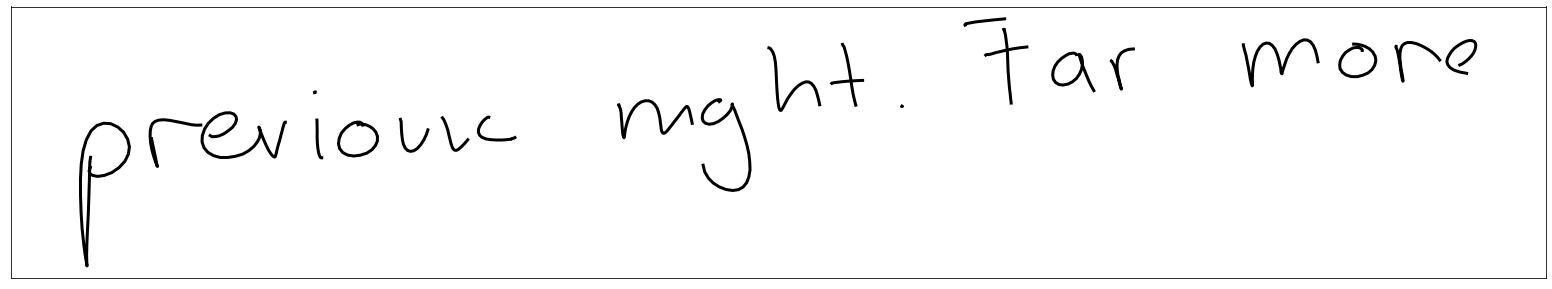

In [0]:
plot_stroke(one_stroke)